# 생물정보학 및 실습 1 - Term Project (Free Analysis) 1/3
생물정보학 및 실습 1   
서울대학교 협동과정 생물정보학전공 2022년 1학기

In [1]:
from collections import Counter, defaultdict
import math
import os
import sys
import pickle
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import pysam

In [52]:
CLIP_BAM_PATH = '../data/binfo1-datapack1/CLIP-35L33G.bam'
FASTA_DIR_PATH    = '../data/chromFa'
HEXAMER_FASTA_PATH = '../stats/hexamers-cres12.fasta'
OCTADECAMER_FASTA_PATH = '../stats/octadecamers.fasta'

## 1. Prepare Reference FASTAs
+ `mm39.chromFa.tar.gz` was downloaded from UCSC Genome Browser
+ FASTAs were extracted into `FASTA_DIR_PATH` by `tar -zxvf`

In [3]:
# Make dctFastaMatch that has {gencode chromID : RefSeq chromID}
lstRefSeqFa = os.listdir(FASTA_DIR_PATH)
dctFastaMatch = {}
for fa in lstRefSeqFa:
    chrId = fa.replace('.fa', '')
    if '_' not in fa:
        dctFastaMatch[chrId] = fa
    else:
        dctFastaMatch[chrId.split('_')[1].replace('v', '.')] = fa

In [4]:
# Validation
dctFastaMatch['GL456210.1']

'chr1_GL456210v1_random.fa'

In [5]:
del dctFastaMatch['chrM']

## 2. Collect Putative Binding Sequences

In [6]:
DEPTH_CUTOFF = 50
CRES_CUTOFF  = 1.2

In [7]:
def get_chr_binding_positions(chrId):
    pileUp = pysam.AlignmentFile(CLIP_BAM_PATH).pileup(chrId)
    lstBindingPositionsPos, lstBindingPositionsNeg = [], []
    for col in pileUp:
        bases = col.get_query_sequences()
        basesPos = [base for base in bases if base.isupper()]
        basesNeg = [base for base in bases if base.islower()]
        if len(basesPos) >= DEPTH_CUTOFF:
            cres = stats.entropy(list(Counter(bases).values()), base=2)
            if cres >= CRES_CUTOFF:
                lstBindingPositionsPos.append(col.reference_pos)
        if len(basesNeg) >= DEPTH_CUTOFF:
            cres = stats.entropy(list(Counter(bases).values()), base=2)
            if cres >= CRES_CUTOFF:
                lstBindingPositionsNeg.append(col.reference_pos)
    return lstBindingPositionsPos, lstBindingPositionsNeg

In [8]:
# Complement: A <--> T, G <--> C
# Dictionary for the Unicode code point
dctComplement = str.maketrans('ACGT', 'TGCA')

In [10]:
def get_binding_sequences(chrId):
    lstBindingPositionsPos, lstBindingPositionsNeg = get_chr_binding_positions(chrId)

    fasta_file_path = os.path.join(FASTA_DIR_PATH, dctFastaMatch[chrId])
    with open(fasta_file_path, 'rt') as fIn:
        assert next(fIn).startswith('>') # Skip header
        seq = fIn.read().strip().replace('\n', '').upper() # Remove new line chr and make lowercase be uppercase

    dctSeqs = Counter()
    for pos in lstBindingPositionsPos:
        dctSeqs.update([seq[pos-8:pos+10]])
    for pos in lstBindingPositionsNeg:
        hexamer = seq[pos-9:pos+9][::-1].translate(dctComplement)
        dctSeqs.update([hexamer])
    return dctSeqs

In [11]:
dctSeqs = Counter()
for chrId, fa in dctFastaMatch.items():
    print(time.ctime(), f'{fa} now opens', sep=' --- ')
    dctSeqs.update(get_binding_sequences(chrId))

Tue Jun  7 15:51:17 2022 --- chr10.fa now opens
Tue Jun  7 15:53:36 2022 --- chr11.fa now opens
Tue Jun  7 15:57:03 2022 --- chr12.fa now opens
Tue Jun  7 15:59:01 2022 --- chr13.fa now opens
Tue Jun  7 16:01:06 2022 --- chr14.fa now opens
Tue Jun  7 16:02:57 2022 --- chr15.fa now opens
Tue Jun  7 16:04:54 2022 --- chr16.fa now opens
Tue Jun  7 16:06:31 2022 --- chr17.fa now opens
Tue Jun  7 16:08:27 2022 --- chr18.fa now opens
Tue Jun  7 16:09:49 2022 --- chr19.fa now opens
Tue Jun  7 16:10:57 2022 --- chr1.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_GL456210v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_GL456211v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_GL456212v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_GL456221v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_GL456239v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr1_MU069434v1_random.fa now opens
Tue Jun  7 16:15:20 2022 --- chr2.fa now opens
Tue Jun  7 16:18:58 2022 --- chr3.fa

In [12]:
dctSeqs.most_common(10)

[('GTGGGTAAGAGCACCCGA', 18),
 ('CTTCTGGAGTGTCTGAAG', 14),
 ('AAAAAAAAAAAAAAAAAA', 14),
 ('CATAATTTGTGGTAGTGG', 11),
 ('TTTTTTTTTTTTTTTTTT', 8),
 ('AAATATAAGAGTTCGGTT', 5),
 ('CTTCTGGTGTGTCTGAAG', 5),
 ('CTCTTCTGGAGTGTCTGA', 5),
 ('CGGGTTCGATTCCCGGTC', 4),
 ('AGAGGCAGGAGGATCTCT', 4)]

In [23]:
dfSeqs = pd.DataFrame(dctSeqs.most_common(), columns=['octadecamer', 'counts']).set_index('octadecamer')
dfSeqs.head()

,counts
octadecamer,
GTGGGTAAGAGCACCCGA,18
CTTCTGGAGTGTCTGAAG,14
AAAAAAAAAAAAAAAAAA,14
CATAATTTGTGGTAGTGG,11
TTTTTTTTTTTTTTTTTT,8


In [24]:
len(dfSeqs)

24729

In [25]:
dfSeqs.to_csv('../stats/octadecamers.txt', sep='\t')

## 3. Discard Noise

In [56]:
dfSeqs = pd.read_table('../stats/octadecamers.txt')
print(len(dfSeqs))
dfSeqs.head()

24729


,octadecamer,counts
0,GTGGGTAAGAGCACCCGA,18
1,CTTCTGGAGTGTCTGAAG,14
2,AAAAAAAAAAAAAAAAAA,14
3,CATAATTTGTGGTAGTGG,11
4,TTTTTTTTTTTTTTTTTT,8


In [62]:
dfSeqs['hexamer'] = dfSeqs.octadecamer.str[6:12]
dfSeqs['centre'] = dfSeqs.hexamer.str[2]
dfSeqs.head()

,octadecamer,counts,hexamer,centre
0,GTGGGTAAGAGCACCCGA,18,AAGAGC,G
1,CTTCTGGAGTGTCTGAAG,14,GAGTGT,G
2,AAAAAAAAAAAAAAAAAA,14,AAAAAA,A
3,CATAATTTGTGGTAGTGG,11,TTGTGG,G
4,TTTTTTTTTTTTTTTTTT,8,TTTTTT,T


In [65]:
dfOctadecamers = dfSeqs[dfSeqs.centre == 'G'][['octadecamer', 'counts']].set_index('octadecamer')
dfOctadecamers

,counts
octadecamer,
GTGGGTAAGAGCACCCGA,18
CTTCTGGAGTGTCTGAAG,14
CATAATTTGTGGTAGTGG,11
AAATATAAGAGTTCGGTT,5
CTTCTGGTGTGTCTGAAG,5
...,...
AGTAATTTGTGCGGGTTT,1
GGTCAAGAGAGTATGAAC,1
ACAGAGCAGTGGTTCTGC,1


In [64]:
dctOctadecamers = dfOctadecamers['counts'].to_dict()
list(dctOctadecamers.items())[0]

('GTGGGTAAGAGCACCCGA', 18)

## 4. Make FASTA

In [66]:
with open(OCTADECAMER_FASTA_PATH, 'wt') as fOut:
    for i, (hexamer, counts) in enumerate(dctOctadecamers.items()):
        for j in range(counts):
            print(
                f'>octadecamer-{i}-{j}',
                hexamer.replace('T', 'U'),
                sep='\n',
                file=fOut
            )

In [67]:
!head $OCTADECAMER_FASTA_PATH

>octadecamer-0-0
GUGGGUAAGAGCACCCGA
>octadecamer-0-1
GUGGGUAAGAGCACCCGA
>octadecamer-0-2
GUGGGUAAGAGCACCCGA
>octadecamer-0-3
GUGGGUAAGAGCACCCGA
>octadecamer-0-4
GUGGGUAAGAGCACCCGA


## 5. Plot WebLogo

WebLogo site에서 진행

In [68]:
from IPython.display import Image

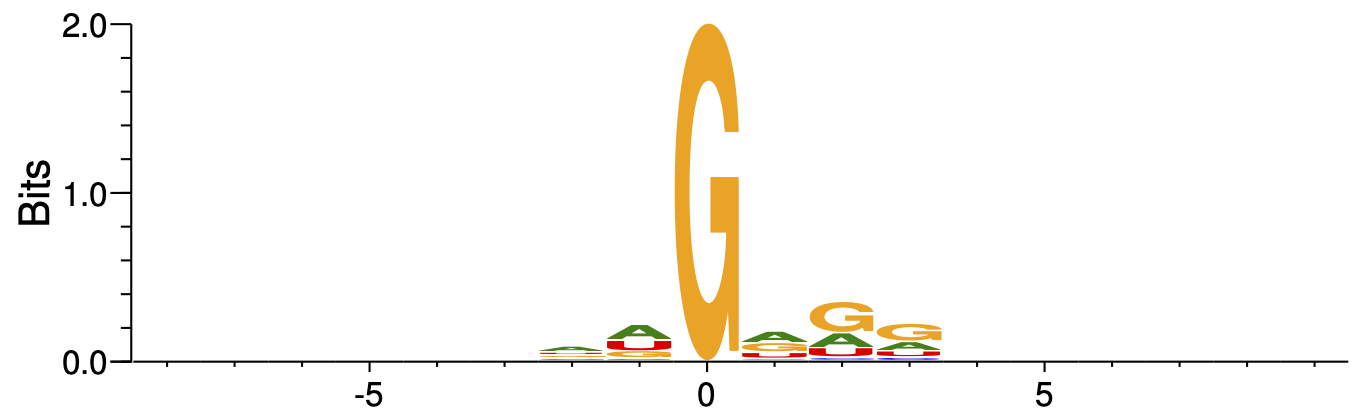

In [69]:
Image('../images/18mer-denoised-bits.png')

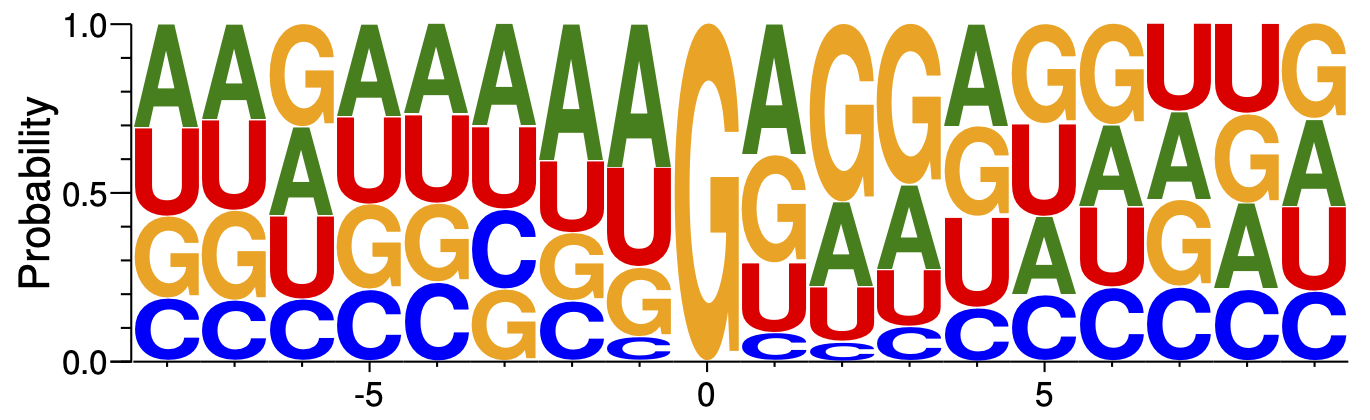

In [70]:
Image('../images/18mer-denoised-probability.png')